# pipecaster tutorial

additional libraries required to execute this notebook:  
* matplotlib  
* scipy  

In [70]:
import pipecaster as pc

# Generate synthetic dataset with 3 informative input matrices 
# and 7 random input matrices.

n_inputs = 10
random_inputs = 7

Xs, y, X_types = pc.make_multi_input_classification(
                        n_informative_Xs=n_inputs-random_inputs, 
                        n_weak_Xs=0,
                        n_random_Xs=random_inputs,
                        weak_noise_sd=None,
                        seed=None,
                        n_classes=2, 
                        n_samples=500, 
                        n_features=100, 
                        n_informative=20, 
                        n_redundant=0, 
                        n_repeated=0, 
                        class_sep=0.8)

## Single Channel vs. Multichannel Classification

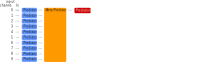

In [71]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.1.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates many of pipecaster's **MultichannelPipeline** and **MultichannelPredictor** classes.  The pipeline takes 10 input matrices with varying degrees of predictive value.  In practice, these matrices might come from ten different data sources or a single data source with ten different feature extraction variants.

**base prediction**  
One GradientBoostingClassifier is trained for each channel.  MultichannelPipeline automatically provides internal cross validation training by default to reduce overfitting of meta-predictors (default training behavior can be altered in the MultichannelPipeline interface).

**meta-prediction**  
The multichannel meta-predictor, **MultichannelPredictor**, concatenates the base predictions into a single meta-feature vector and trains a meta-predictor (in this case scikit-learn's support vector machine classifier SVC).

In [72]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,layer_1
channel,,
0,GradientBoostingClassifier,SVC_MC
1,GradientBoostingClassifier,▽
2,GradientBoostingClassifier,▽
3,GradientBoostingClassifier,▽
4,GradientBoostingClassifier,▽
5,GradientBoostingClassifier,▽
6,GradientBoostingClassifier,▽
7,GradientBoostingClassifier,▽
8,GradientBoostingClassifier,▽


**Notes on dataframe visualization**:  
* Inverted triangles indicate that the channels are spanned by the multichannel pipe shown directly above. 
* The _MC suffix indicates that the SVC classifier is being used for multichannel prediction (wrapped in the MultichannelPRedictor class)
* The integer channel and layer indices seen on the left and top can be used to reference specific object instances in the pipeline (see MultichannelPipeline interface annotations).  

In [73]:
mclf1.fit(Xs, y)

,layer_0,out_0,layer_1,out_1
channel,,,,
0,{GradientBoostingClassifier}cvtr,→,{SVC_MC}tr,→
1,{GradientBoostingClassifier}cvtr,→,▽,
2,{GradientBoostingClassifier}cvtr,→,▽,
3,{GradientBoostingClassifier}cvtr,→,▽,
4,{GradientBoostingClassifier}cvtr,→,▽,
5,{GradientBoostingClassifier}cvtr,→,▽,
6,{GradientBoostingClassifier}cvtr,→,▽,
7,{GradientBoostingClassifier}cvtr,→,▽,
8,{GradientBoostingClassifier}cvtr,→,▽,


**Notes on dataframe visualization**: 
* GradientBoostingClassifier appears in brackets followed by 'cvtr' to indicate that the classifier has been wrapped with a class that provides internal cross validation training to prevent overfitting of downstream metaclassifiers.
* SVC_MC appears in brackets followed by 'tr' to indicate that it has been wrapped to provide a transform() method that predictors ordinarily lacks. 
* Output layers are indicated showing which channels generate outputs.

### Performance analysis

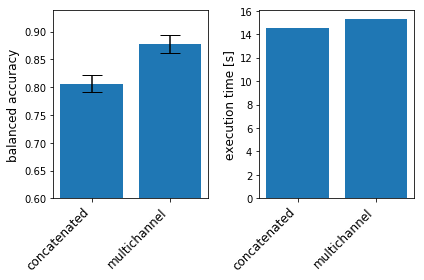

In [74]:
%matplotlib inline
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

n_cpus = pc.count_cpus()

# Test a MultichannelPipeline in a cross validation experiment
t = time.time()
pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=8, n_processes=n_cpus)
pc_time = time.time() - t

# Test a single channel scikit-learn pipeline in a cross validation experiment
X = np.concatenate(Xs, axis=1)
clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=8, n_jobs=n_cpus)
sk_time = time.time() - t

# Plot the cross validation results
fig, axes = plt.subplots(1, 2)
xlabels = ['concatenated', 'multichannel']
axes[0].bar(xlabels, [np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr=[sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
axes[0].set_ylim(.60)
axes[0].set_ylabel('balanced accuracy', fontsize=12)
axes[0].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
axes[1].bar(xlabels, [np.mean(sk_time), np.mean(pc_time)])
axes[1].set_ylabel('execution time [s]', fontsize=12)
axes[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()
# plt.savefig('performance_comparison.svg')

**Results**  
The multichannel pipecaster pipeline performs better on this task than the pipeline architectures that take concatenated features.  This performance enhancement, which is sometimes seen with real data, may be due to the tendency for meta-predictors to correct errors found in the base predictors and perhaps due to increased diversity of the features used by the base predictors.

This example is a proxy for a more thorough demonstration of performance improvement, which would involve a full hyperparameter optimization for each pipeline architecture.  The early stopping GradientBoostingClassifier method shown here is a decent proxy though, because performance of this classifier is not very sensitive to hyperparameter values, and model complexity is automatically set by increasing the number of boosting rounds until performance on a validation set stops increasing.

## Feature Selection and Channel Selection

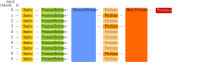

In [20]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.2.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example builds on example 1.1 by adding scaling, feature selection, and channel selection layers at the beginning of the pipeline.  ML models often perform better if low quality and non-informative features are filtered out using feature selection methods.  Filtering out low quality features improves performance when the cost of overfitting the noise in these feautres outweight the benefit of their informative signal.  

**scaling and feature selection**  
The scaler and feauture selector algorithms used in the example below, StandardScaler() and SelectPercentile(), are scikit-learn estimator/transformers that are broadcast across all inputs.  

**channel selection**  
The channel selector used in this example, **SelectKBestScores**, computes a univariate feature score for each feature of a matrix then aggregates the score into a single value using an aggregator function (in this example np.mean).  The top k scoring channels are then selected for output (k=3 in this example).

Related classes: **SelectPercentBestScores**, **SelectHighPassScores**, **SelectVarianceHighPassScores**

**base prediction** & **meta-prediction** 
Same as example 1.1

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf1.add_layer(StandardScaler())
mclf1.add_layer(SelectPercentile(percentile=25))
mclf1.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=3))
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

,layer_0,layer_1,layer_2,layer_3,layer_4
channel,,,,,
0,StandardScaler,SelectPercentile,SelectKBestScores,GradientBoostingClassifier,SVC_MC
1,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
2,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
3,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
4,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
5,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
6,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
7,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
8,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽


In [22]:
df = mclf1.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestScores,→,{GradientBoostingClassifier}cvtr,→,{SVC_MC}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
2,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
8,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.
* The output arrow for layer 2 show the real channel selection that occured during pipeline fitting.

### Performance analysis

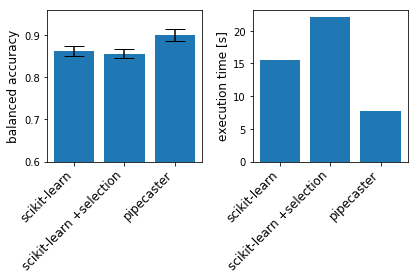

In [23]:
%matplotlib inline
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

n_cpus = pc.count_cpus()

t = time.time()
pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=10, n_processes=n_cpus)
pc_time = time.time() - t

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=100)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_time = time.time() - t

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_ns_time = time.time() - t

fig, axes = plt.subplots(1, 2)
xlabels = ['scikit-learn', 'scikit-learn +selection', 'pipecaster']
axes[0].bar(xlabels, [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr=[sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
axes[0].set_ylim(.6)
axes[0].set_ylabel('balanced accuracy', fontsize=12)
axes[0].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
axes[1].bar(xlabels, [np.mean(sk_ns_time), np.mean(sk_time), np.mean(pc_time)])
axes[1].set_ylabel('execution time [s]', fontsize=12)
axes[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()

**Results**  
The pipecaster pipeline performs better on this task than pipeline architectures that take concatenated features (scikit-learn, and scikit-learn + selection).  The synthetic dataset used in this example consists of 3 informative input matrices and 7 random matrices. 

## Selecting Channels with ML probes

This example demonstrates how to select input channels based on the the performance of temporary ML probes.  Here the **SelectKBestProbes** class is used in conjunction with a low complexity GradientBoostingClassifier probe.  SelectKBestProbes computes a cross validation run on each channel (one model per channel) and uses prediction accuracy as a nonlinear estimate of channel information content.  The ML probes and their predictions are then discarded and the selected channels passed through to the next pipeline layer. The pipeline architecture is identical to the one illustrated in example 1.2, except SelectKBestProbes replaces SelectKBestScores.

Related classes: **SelectPercentBestProbes**, **SelectHighPassProbes**, **SelectVarianceHighPassProbes**

In [24]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
import pipecaster as pc

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf2 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf2.add_layer(StandardScaler())
mclf2.add_layer(SelectPercentile(percentile=25))
probe = GradientBoostingClassifier(n_estimators=10)
mclf2.add_layer(pc.SelectKBestProbes(predictor_probe=probe, cv=3, scorer='auto', k=3))
mclf2.add_layer(early_stopping_GBC)
mclf2.add_layer(pc.MultichannelPredictor(SVC()))
mclf2

,layer_0,layer_1,layer_2,layer_3,layer_4
channel,,,,,
0,StandardScaler,SelectPercentile,SelectKBestProbes,GradientBoostingClassifier,SVC_MC
1,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
2,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
3,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
4,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
5,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
6,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
7,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽
8,StandardScaler,SelectPercentile,▽,GradientBoostingClassifier,▽


In [25]:
df = mclf2.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,layer_4,out_4,input_type
channel,,,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestProbes,→,{GradientBoostingClassifier}cvtr,→,{SVC_MC}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
2,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,→,{GradientBoostingClassifier}cvtr,→,▽,,informative
8,StandardScaler,→,SelectPercentile,→,▽,,→,,▽,,random


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.

In [26]:
accuracies = pc.cross_val_score(mclf2, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

balanced accuracy = 0.9219999999999999 +/- 0.013564659966250527


## In-pipeline Model Screening with SelectKBestModels

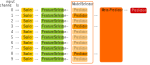

In [29]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.4.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates use of the model selector class **SelectKBestModels**.  This class does an internal cross validation run on each channel (one model per channel) and uses the results to estimate model performance and generate outputs for meta-prediction.  The final base predictor models are trained on the entire training set (no internal cross validation).

Related classes: **SelectPercentBestModels**, **SelectHighPassModels**, **SelectVarianceHighPassModels**

In [30]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pipecaster as pc

mclf3 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf3.add_layer(StandardScaler())
mclf3.add_layer(SelectPercentile(percentile=25))
mclf3.add_layer(pc.SelectKBestModels(KNeighborsClassifier(), cv=5, scorer='auto', k=3))
mclf3.add_layer(pc.MultichannelPredictor(SVC()))
mclf3

,layer_0,layer_1,layer_2,layer_3
channel,,,,
0,StandardScaler,SelectPercentile,SelectKBestModels,SVC_MC
1,StandardScaler,SelectPercentile,▽,▽
2,StandardScaler,SelectPercentile,▽,▽
3,StandardScaler,SelectPercentile,▽,▽
4,StandardScaler,SelectPercentile,▽,▽
5,StandardScaler,SelectPercentile,▽,▽
6,StandardScaler,SelectPercentile,▽,▽
7,StandardScaler,SelectPercentile,▽,▽
8,StandardScaler,SelectPercentile,▽,▽


In [31]:
df = mclf3.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3,input_type
channel,,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,SelectKBestModels,→,{SVC_MC}tr,→,informative
1,StandardScaler,→,SelectPercentile,→,▽,→,▽,,informative
2,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
3,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
4,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
5,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
6,StandardScaler,→,SelectPercentile,→,▽,,▽,,random
7,StandardScaler,→,SelectPercentile,→,▽,→,▽,,informative
8,StandardScaler,→,SelectPercentile,→,▽,,▽,,random


**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.

In [ ]:
accuracies = pc.cross_val_score(mclf3, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

## Use Channel Mapping to Mix-and-Match Channels and Algorithms

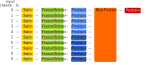

In [54]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.5.svg'))

*This pipeline is implemented with the code in the next cell.*  

The previous examples have broadcast a single algorithm across all channels, but it's easy to set each algorithm separately by providing a list with one algorithm for each channel (not shown), or by providing an alternating list of integers specifying the number of channels to map and algorithms to map to those channels (see next cell).

In [55]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import pipecaster as pc

mclf4 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf4.add_layer(StandardScaler())
mclf4.add_layer(SelectPercentile(percentile=25))
mclf4.add_layer(5, LogisticRegression(), 5, KNeighborsClassifier())
mclf4.add_layer(pc.MultichannelPredictor(SVC()))
mclf4

,layer_0,layer_1,layer_2,layer_3
channel,,,,
0,StandardScaler,SelectPercentile,LogisticRegression,SVC_MC
1,StandardScaler,SelectPercentile,LogisticRegression,▽
2,StandardScaler,SelectPercentile,LogisticRegression,▽
3,StandardScaler,SelectPercentile,LogisticRegression,▽
4,StandardScaler,SelectPercentile,LogisticRegression,▽
5,StandardScaler,SelectPercentile,KNeighborsClassifier,▽
6,StandardScaler,SelectPercentile,KNeighborsClassifier,▽
7,StandardScaler,SelectPercentile,KNeighborsClassifier,▽
8,StandardScaler,SelectPercentile,KNeighborsClassifier,▽


In [56]:
mclf4.fit(Xs, y)

,layer_0,out_0,layer_1,out_1,layer_2,out_2,layer_3,out_3
channel,,,,,,,,
0,StandardScaler,→,SelectPercentile,→,{LogisticRegression}cvtr,→,{SVC_MC}tr,→
1,StandardScaler,→,SelectPercentile,→,{LogisticRegression}cvtr,→,▽,
2,StandardScaler,→,SelectPercentile,→,{LogisticRegression}cvtr,→,▽,
3,StandardScaler,→,SelectPercentile,→,{LogisticRegression}cvtr,→,▽,
4,StandardScaler,→,SelectPercentile,→,{LogisticRegression}cvtr,→,▽,
5,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
6,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
7,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,
8,StandardScaler,→,SelectPercentile,→,{KNeighborsClassifier}cvtr,→,▽,


In [57]:
accuracies = pc.cross_val_score(mclf4, Xs, y, scorer=balanced_accuracy_score, cv=5)
print('balanced accuracy = {} +/- {}'.format(np.mean(accuracies), sem(accuracies)))

balanced accuracy = 0.9 +/- 0.008366600265340756


## In-pipeline Model Screening

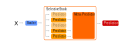

In [58]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.6.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates the use of pipecaster's **SelectiveStack** class and its performance advantage over scikit-learn's VotingClassifier.  SelectiveStack is a single-channel ensemble classifier stack with the functionality of scikit-learn's VotingClassifier, VotingPredictor, StackingClassifier, and StackingRegressor classes.  In addition, SelectiveStack allows you to select the best performing base models during fitting of the ensemble.  Base classifiers are usually trained via internal cross-validation in predictor stacks like these, and pipecaster takes advantage of the cross validation results to estimate the performance of each model in the ensemble.  In the example here, the top 2 models are selected and their inferences averaged via soft voting to generate an ensemble prediction.  Dropping inaccurate models from an ensemble can increase performance.

**SelectiveStack** uses **SoftVotingClassifier** in this example to combine the inferences of the base classifiers.  Pipecaster also provides **HardVotingClassifier** and **AggregatingRegressor** classes for use in this context, and any appropriate scikit-learn predictor may be substituted (e.g. SVC or SVR).

In [59]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

import pipecaster as pc

n_cpus = pc.count_cpus()

X, y_single = make_classification(n_classes=2, n_samples=500, n_features=100, 
                           n_informative=5, class_sep=0.6)

# scikit-learn voting classifier
sk_voter = VotingClassifier(estimators=[('NN', MLPClassifier()), 
                                        ('LR', LogisticRegression()), 
                                        ('GBC', GradientBoostingClassifier()),
                                        ('RFC', RandomForestClassifier()),
                                        ('NB', GaussianNB())], 
                                        voting='soft')
sk_clf = Pipeline([('scaler', StandardScaler()), 
                ('voting classifier', sk_voter)])

# pipecaster SelectiveStack that selects all input models (i.e. no selection)
mclf5 = pc.MultichannelPipeline(n_channels=1)
mclf5.add_layer(StandardScaler())
mclf5.add_layer(pc.SelectiveStack(
                 base_predictors=[MLPClassifier(), 
                                  LogisticRegression(), 
                                  KNeighborsClassifier(),
                                  GradientBoostingClassifier(),
                                  RandomForestClassifier(),
                                  GaussianNB()], 
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=None, base_processes=n_cpus))

# pipecaster SelectiveStack that selects the 2 best models
mclf6 = pc.MultichannelPipeline(n_channels=1)
mclf6.add_layer(StandardScaler())
mclf6.add_layer(pc.SelectiveStack(
                 base_predictors=[MLPClassifier(), 
                                  LogisticRegression(), 
                                  KNeighborsClassifier(),
                                  GradientBoostingClassifier(),
                                  RandomForestClassifier(),
                                  GaussianNB()], 
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=pc.RankScoreSelector(k=2), base_processes=n_cpus))

,layer_0,layer_1
channel,,
0,StandardScaler,SelectiveStack


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

sk_accuracies = cross_val_score(sk_clf, X, y_single, scoring='balanced_accuracy', cv=5)
non_sel_accuracies = pc.cross_val_score(mclf5, [X], y_single, scorer=balanced_accuracy_score, 
                                        cv=5)
sel_accuracies = pc.cross_val_score(mclf6, [X], y_single, scorer=balanced_accuracy_score, 
                                    cv=5)

Text(0, 0.5, 'balanced accuracy')

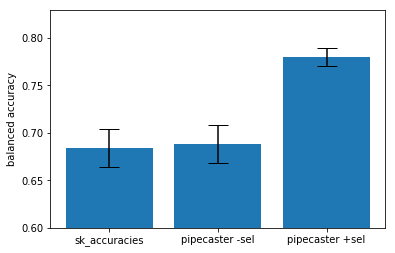

In [61]:
import matplotlib.pyplot as plt
from scipy.stats import sem
plt.bar(['sk_accuracies', 'pipecaster -sel', 'pipecaster +sel'],
        [np.mean(sk_accuracies), np.mean(non_sel_accuracies), np.mean(sel_accuracies)], 
        yerr= [sem(sk_accuracies), sem(non_sel_accuracies), sem(sel_accuracies)], capsize=10)
plt.ylim(.6)
plt.ylabel('balanced accuracy')

In [ ]:
mclf6.fit([X], y_single)

In [64]:
print('Models selected by the SelectiveStack:')
stack = mclf6.get_model_from_channel(layer_index=1, channel_index=0)
[pc.get_descriptor(bp) for i, bp in enumerate(stack.base_predictors) if i in stack.get_support()]

Models selected by the SelectiveStack:


['GradientBoostingClassifier', 'RandomForestClassifier']

The cell above illustrates two useful functions: 
* **get_model_from_channel()** retrieves a fit model from the pipeline based on layer and channel indices.
* **stack.get_support()** get the indices of the base predictors that were selected during fitting.

## In-pipeline Hyperparameter Screening

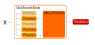

In [65]:
from IPython.display import SVG, display
display(SVG('images/tutorial_1.7.svg'))

*This pipeline is implemented with the code in the next cell.*  

This example illustrates the use of pipecaster's **GridSearchStack** class to conduct an in-pipeline hyperparameter screen.  A small in-pipeline screen is conducted to test different hyperparameters for GradientBoostingClassifier and inferences are pooled using soft voting of all models or just the models with the top 3 hyperparameter sets.

In [66]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.model_selection import ParameterGrid

from sklearn.pipeline import Pipeline

import pipecaster as pc

screen = {
     'learning_rate':[0.1, 10], 
     'n_estimators':[5, 25], 
     'max_depth':[3, 20]
}

X, y_single = make_classification(n_classes=2, n_samples=500, n_features=100, 
                                  n_informative=5, n_redundant=20, class_sep=.5)

# pipecaster SelectiveStack that selects all input models (i.e. no selection)
clf1 = pc.GridSearchStack(
                 param_dict=screen, 
                 base_predictor_cls=GradientBoostingClassifier,
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=None, base_processes=pc.count_cpus())

# pipecaster SelectiveStack that selects the 3 best models
clf2 = pc.GridSearchStack(
                 param_dict=screen, 
                 base_predictor_cls=GradientBoostingClassifier,                 
                 meta_predictor=pc.SoftVotingClassifier(),
                 internal_cv=5, scorer='auto',
                 score_selector=pc.RankScoreSelector(k=3), base_processes=pc.count_cpus())

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

accuracies_1 = cross_val_score(clf1, X, y_single, scoring='balanced_accuracy', cv=5)
accuracies_2 = cross_val_score(clf2, X, y_single, scoring='balanced_accuracy', cv=5)

Text(0, 0.5, 'balanced accuracy')

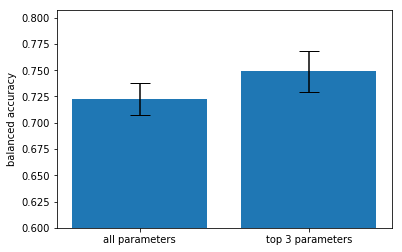

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import sem
plt.bar(['all parameters', 'top 3 parameters'],
        [np.mean(accuracies_1), np.mean(accuracies_2)], 
        yerr= [sem(accuracies_1), sem(accuracies_2)], capsize=10)
plt.ylim(.6)
plt.ylabel('balanced accuracy')

In [69]:
print('Models & parameters selected by the SelectiveStack:')
import pandas as pd
clf2.fit(X, y_single)
pd.set_option('display.max_colwidth', 79)
clf2.get_results_df()

Models & parameters selected by the SelectiveStack:


,selections,parameters
score,,
0.783949,+,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 25}"
0.741892,+,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 5}"
0.729940,+,"{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 25}"
0.725956,-,"{'learning_rate': 10, 'max_depth': 20, 'n_estimators': 5}"
0.722052,-,"{'learning_rate': 0.1, 'max_depth': 20, 'n_estimators': 5}"
0.713619,-,"{'learning_rate': 10, 'max_depth': 20, 'n_estimators': 25}"
0.520616,-,"{'learning_rate': 10, 'max_depth': 3, 'n_estimators': 5}"
0.520616,-,"{'learning_rate': 10, 'max_depth': 3, 'n_estimators': 25}"
